# Выявление закономерностей, определяющих успешность игры. Интернет-магазин «Стримчик».

Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats as st
import math
from scipy.stats import bartlett
import seaborn as sns
from scipy.stats import ttest_ind


In [3]:
# Чтение данных из файла
try:
    shop = pd.read_csv('/datasets/games.csv')
except:
    shop = pd.read_csv(r'games.csv')

## Подготовим данные
* Заменим названия столбцов (приведем к нижнему регистру);
* Преобразуем данные в нужные типы. Опишем, в каких столбцах заменили тип данных и почему;
* Обработаем пропуски при необходимости:
* Объясним, почему заполнили пропуски определённым образом или почему не стали это делать;
* Опишем причины, которые могли привести к пропускам;
* Обратим внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберем это значение и опишем, как его обработать;
* Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.


In [4]:
shop.info()
shop.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<font color='blue'> Проанализируем процент пропусков </font>

In [5]:
pd.DataFrame(round((shop.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
Name,0.01
Platform,0
Year_of_Release,1.61
Genre,0.01
NA_sales,0
EU_sales,0
JP_sales,0
Other_sales,0
Critic_Score,51.32
User_Score,40.09


In [6]:
shop.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [7]:
# проверим полные дубликаты 
shop.duplicated().sum()

0

Перейдем к предобработке

In [8]:
# заменим названия столбцов, приведем к нижнему регистру
shop.columns = shop.columns.str.lower()
shop.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Проверим на пропуски

In [9]:
# Проверка, подсчет количества NaN - значений во всех столбцах
shop.isna().sum(axis=0)

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

* в стлобцах 'name' и 'genre' по 2 пропуска. Давайте их просто удалим
* столбец "year_of_release" имеет 269 пропусков. Заменим на индикаторноге значение 111
* пропуски в столбцах с оценками пользователей и критиков "user_score" и "critic_score" заменим на -1. Этим действием мы сможем выделить данные с пропущенными оценками и не перемешать их с другими (оценка всегда больше 0)
* пропуски в столбце "rating" заменим на значение rp, что соответствует действительности - на момент анализа рейтинга нет, он ожидается.

In [10]:
# Удалим пропуски в 'name' и 'genre'
shop.dropna(subset=['name'], inplace=True)
shop.dropna(subset=['genre'], inplace=True)
shop.isna().sum(axis=0)

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

In [11]:
# создадим функцию для замены пропущенных значений 
def replace(df, column, required):
    df[column].fillna(required, inplace=True)

In [12]:
# столбец "year_of_release" имеет 269 пропусков. Заменим на индикаторноге значение 111
replace(shop, 'year_of_release', 111)

In [13]:
# Заменим пропуски в столбце 'user_score' 
replace(shop, 'user_score', -1)
# Заменим пропуски в столбце 'critic_score'
replace(shop, 'critic_score', -1)

In [14]:
# Заменим пропуски в столбце "rating" на значения "rp" - рейтинг ожидается
replace(shop, 'rating', 'rp')

In [15]:
shop.isna().sum(axis=0)

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Отлично, c пропусками разобрались.

Приведем данные к нужным типам

In [16]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null object
rating             16713 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Приведем:
* year_of_release - приведем к целочисленному
* user_score - это же численный показатель, а имеет тип object - меняем на 'float'.
Остальные типы столбцов в порядке.

In [17]:
# приведем год к целочисленному типу "int" 
shop['year_of_release'] = shop['year_of_release'].astype('int64')
shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null object
rating             16713 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.5+ MB


In [18]:
# приведем user_score к числу
# shop['user_score'] = shop['user_score'].astype('float64')
# здесь появляется ошибка "could not convert string to float: 'tbd'". Значит для части значений оценка не определена.
# Сколько таких значений?

In [19]:
shop.query('user_score =="tbd"').shape[0]

2424

Аббревиатура 'tbd" - To Be Determined. Пишется тогда, когда игра имеет недостаточное количество отзывов (менее 4) для подсчета рейтинга пользователей и его публикации.Эти данные можно считать пропусками, т.к. оценки нет. Заменим на индикаторное значение "-1", по аналогии с пропусками

In [20]:
# заменим "tbd" на ""-1"
shop.loc[shop['user_score']=='tbd', 'user_score'] = -1
# приведем к целочисленному типу "int" 
shop['user_score'] = shop['user_score'].astype('float64')

In [21]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


In [22]:
# Посчитаем количество продаж во всех регионах и запишем их в отдельный столбец
shop['total_sales'] = shop['na_sales'] + shop['eu_sales'] + shop['jp_sales'] + shop['other_sales']
shop.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,rp,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,rp,31.38


### Вывод: данные подготовили, с пропусками в данных разобрались. Причина появления пропусков? Как предположение. Данные собирались с 1980 года. Возможно, что в то время еще не было инструментов, которые могли бы консолидировать оценки пользователей и экспертов. Тем более, что игровые платформы разные, данные из открытых и различных источников. Также, надо учитывать, что данные собраны по разным регионам, в которых могут быть разные информационные системы и языки (например японский пользователь не напишет на английском сайте отзыв и наоборот).

## Проведем исследовательский анализ данных  

* Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?  
* Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?  
* Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.  
* Не будем учитывать в работе данные за предыдущие годы.  
* Определим, какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
* Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.  
* Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.  
* Соотнесем выводы с продажами игр на других платформах.  
* Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами? 

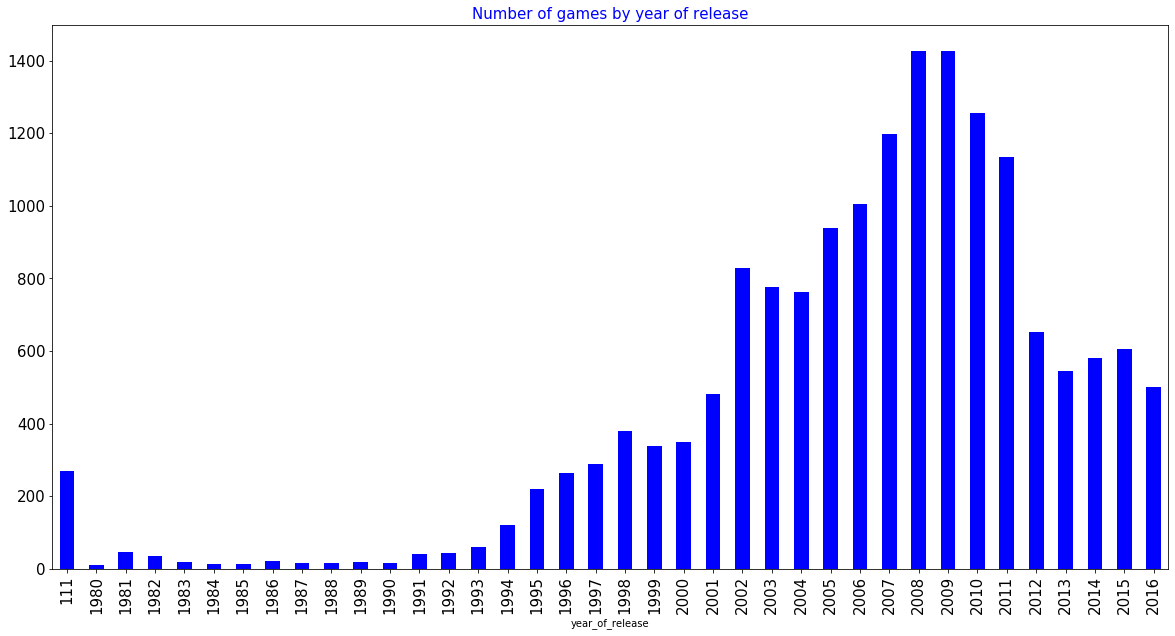

In [23]:
# Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
(shop
   .pivot_table(index='year_of_release', values=['name'],
                aggfunc='count')
   .sort_values(by='year_of_release', ascending=True)
   .plot(kind='bar',figsize=(20, 10), fontsize=15, color='b')
)
plt.title('Number of games by year of release', fontsize=15, color='b')
plt.legend(fontsize=15).set_visible(False);

Посмотрев на это распределение, сразу хочется спросить - куда уходят игры? Не в интернет, соцсети и мобильные устройства случайно? Мы перестаем потихоньку играть на любых платформах, кроме интернета. Пик популярности и наибольшее число релизов были в 2007-2011 годах. Данными "111"(это наше индикаторное значение) можно пренебречь. Также видно, что пик продаж уже прошел и продажи начали стабилизироваться начиная с 2012 года. Будем рассматривать этот период как актуальный, для того, чтобы спланировать 2017 год. 

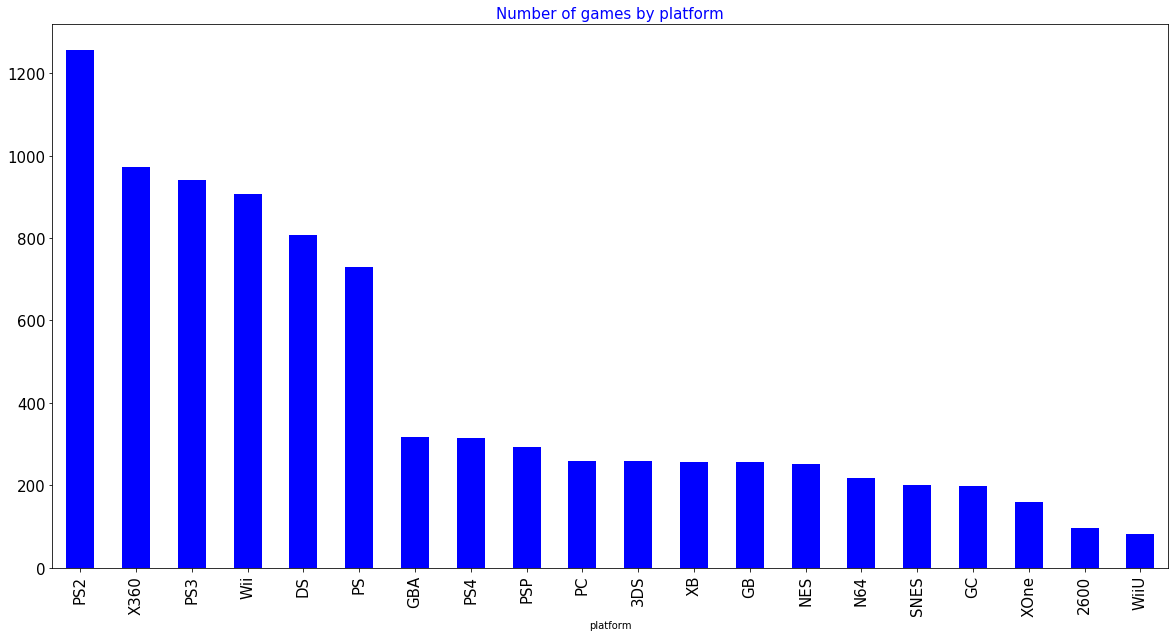

In [24]:
# Посмотрим, как менялись продажи по платформам. Взьмем 20 платформ
(shop
     .groupby(by='platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False).head(20)
     .plot(kind='bar',figsize=(20, 10), fontsize=15, color='b')
)
plt.title('Number of games by platform', fontsize=15, color='b')
plt.legend(fontsize=15).set_visible(False);
#легенду сдеклали невидимой :) Но она есть!

Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
Явно видно 6 платформ лидеров PS, DS, Wii, PS3, X360, PS2.

In [25]:
# Сделаем сводную таблицу где сгруппируем данные по платформе, затем подсчитаем сумму продаж
sumsales_pivot = shop.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
sumsales_pivot.columns = ['sum_sales']
sumsales_pivot.reset_index(inplace = True)
sumsales_pivot.sort_values(by = 'sum_sales', ascending= False).head(6)

,platform,sum_sales
16,PS2,1255.77
28,X360,971.42
17,PS3,939.65
26,Wii,907.51
4,DS,806.12
15,PS,730.86


In [26]:
# Сделаем сводную таблицу, где сгруппируем данные по платформе и году релиза и подсчитаем сумму продаж для каждого года
sumsalesyear_pivot = shop.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
sumsalesyear_pivot.columns = ['sum_sales']
sumsalesyear_pivot.reset_index(inplace = True)
sumsalesyear_pivot.head()

,platform,year_of_release,sum_sales
0,2600,111,10.50
1,2600,1980,11.38
2,2600,1981,35.68
3,2600,1982,28.88
4,2600,1983,5.84


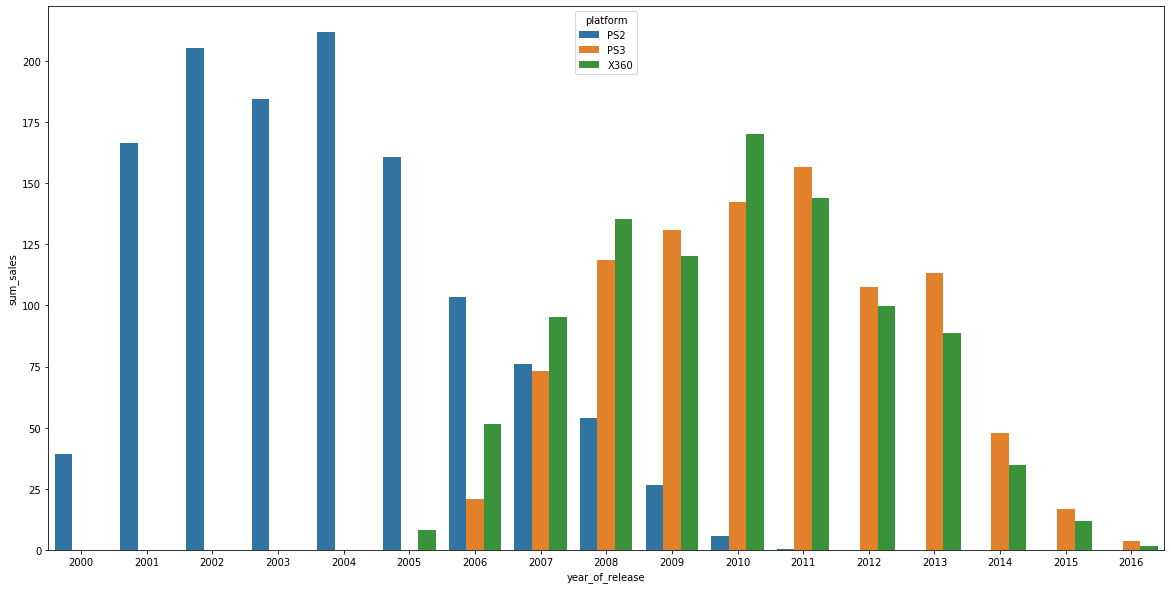

In [27]:
# Построим графики,  которые наглядно покажут сколько живут платформы, возьмем данные после 1991 года
# Разобьем по 3 платформы, для наглядности. 
plt.figure(figsize=(20, 10))
top_platform = sumsalesyear_pivot.query('platform in ["PS2","X360","PS3"] & year_of_release > 1991')
ax = sns.barplot(x="year_of_release", y="sum_sales", hue="platform", data=top_platform)

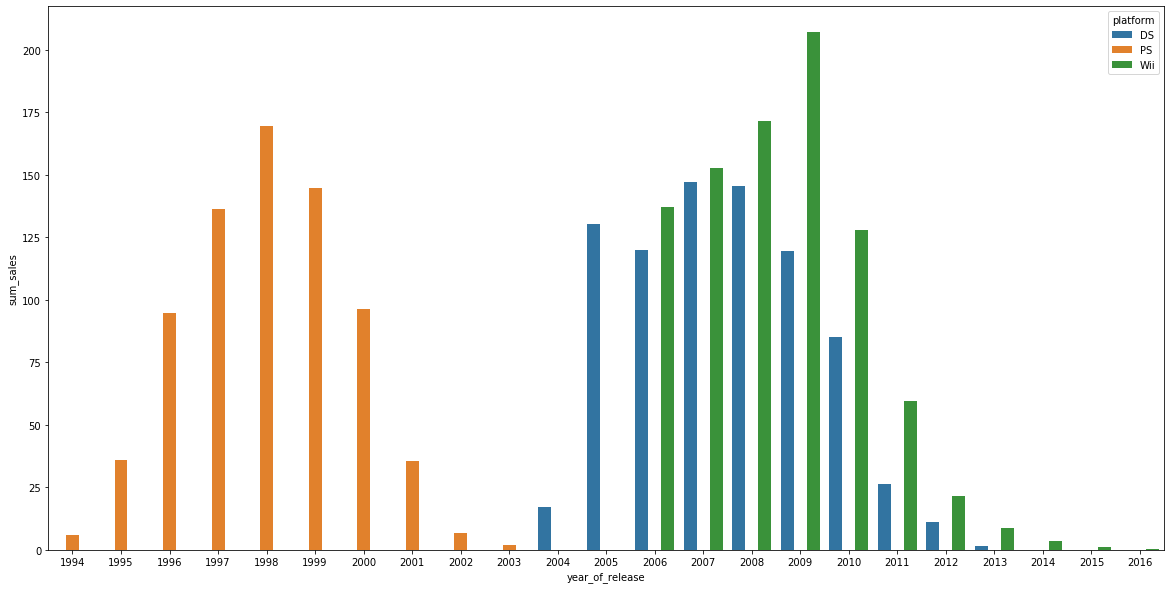

In [28]:
# Построим barplot который наглядно покажет сколько живут платформы, сохраним условие, данные после 1991 года
# Разобьем по 3 платформы, для наглядности. 
plt.figure(figsize=(20, 10))
top_platform = sumsalesyear_pivot.query('platform in ["Wii","DS", "PS"] & year_of_release > 1991')
ax = sns.barplot(x="year_of_release", y="sum_sales", hue="platform", data=top_platform)

На графиках хорошо видно, что цикл жизни платформы около 10 лет. А еще, что интересно, этот цикл очень похож на нормальное распределение :)

Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не будем учитывать в работе данные за предыдущие годы.
* Возьмем период с 2012 года по 2016 год, как наиболее актуальный по количеству продаж на сегодняшний день. Предположим, что продажи стабилизировались. Если брать более ранний период, данные будут искажены из-за пика продаж 2007-2011 годов.

Определим, какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
* если посмотреть на графики, можно сделать выводы, что все платформы, кроме PS3 и X360 почти ушли с рынка. Ими пользуются "энтузиасты". В нашем исследовании давайтие предположим, что лидерами останутся PS3 и X360. Остальными платформами можно пренебречь. Все платформы прошли свой пик и находятся в фазе падения. На этом этапе исследования объективно можно сделать вывод, что рынок кардинально изменился. Надо срочно перегруппировать усилия на новые ниши рынка, иначе магазин можно будет закрывать. В реальности так и произошло. Нет больше огромного рынка игр для приставок. Теперь все играют на телефонах, в соцсетях или просто в интернете. Можно было бы закончить исследование, но надо учиться дальше :) Давайте посмотрим, а что реально с рынком игр происходит? Вот распределение по долям глобального рынка:

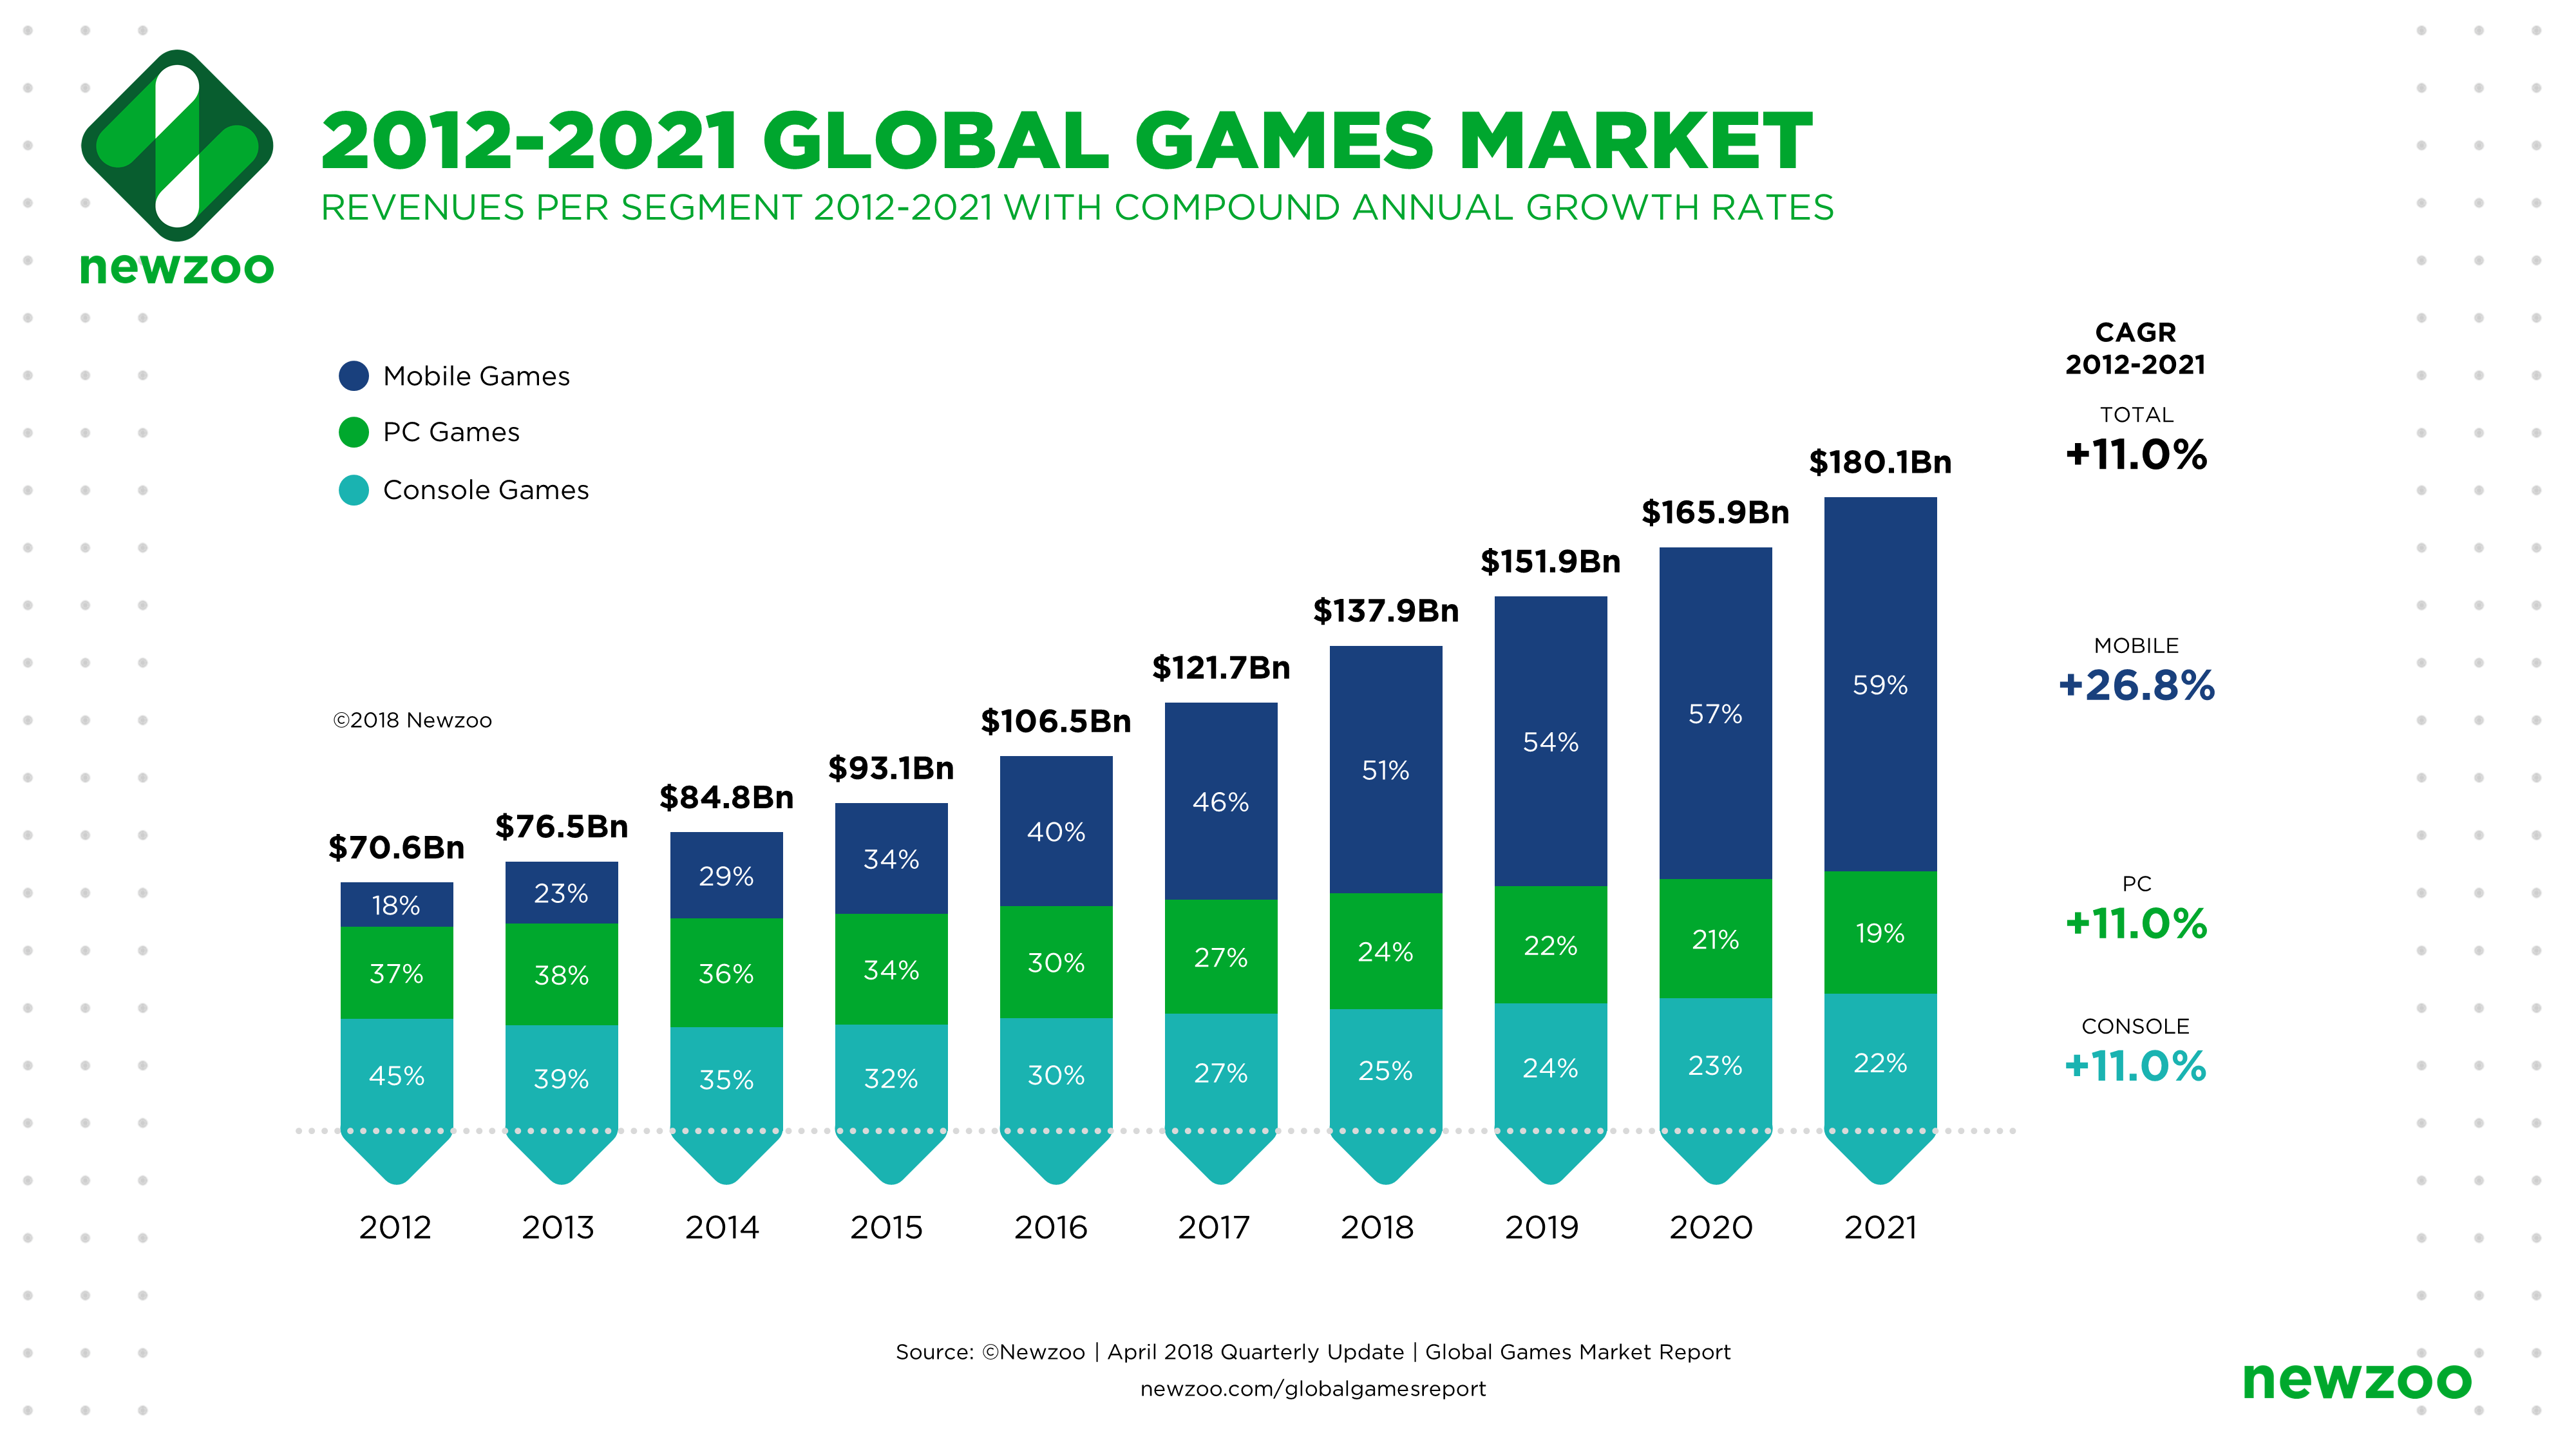

Хорошо видно, что рынок игровых приставок стабилизировался и расти не собирается. Даже с учетом ковидных изоляций и других катаклизмов. Надо это учитывать при планировании бюджета. Необходимо правильно расставить акценты. И обратить пристальное внимание на растущие сегменты рынка.

In [29]:
# Соберем датафрейм с информацией по играм за актуальный период 2012-2016
current_period = shop[shop['year_of_release'] >= 2012]

# Сделаем сводную таблицу где сгруппируем данные по платформе и году релиза, затем подсчитаем сумму продаж для каждого года
sumsalesyear_2012_2016 = current_period.pivot_table(index = ['platform','year_of_release'], values = 'total_sales', aggfunc = 'sum')
sumsalesyear_2012_2016.columns = ['sum_sales']
sumsalesyear_2012_2016.reset_index(inplace = True)
sumsalesyear_2012_2016.tail()

,platform,year_of_release,sum_sales
44,X360,2016,1.52
45,XOne,2013,18.96
46,XOne,2014,54.07
47,XOne,2015,60.14
48,XOne,2016,26.15


<font color='blue'> Построим боксплоты для 10 платформ-лидеров, уберем выбросы, сделаем подписи, уберем технические строчки </font>

In [30]:
games_total_sales = current_period.pivot_table(
    index=['platform', 'year_of_release'], 
                  values='total_sales', 
                  aggfunc='sum').sort_values(
    by='total_sales', ascending=False).reset_index().head(10)

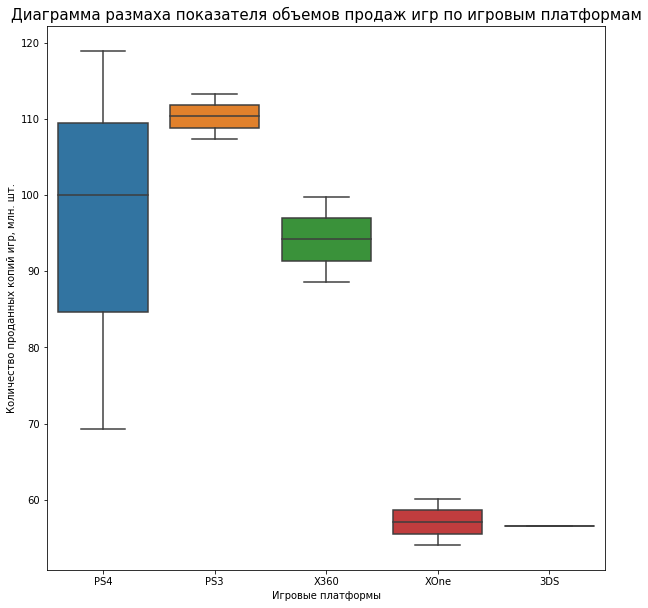

In [31]:
plt.figure(figsize=(10,10))
sns.boxplot(x='platform', y='total_sales', showfliers = False, data=games_total_sales)

plt.title('Диаграмма размаха показателя объемов продаж игр по игровым платформам', fontsize=15)
plt.xlabel('Игровые платформы')
plt.ylabel('Количество проданных копий игр, млн. шт.')
plt.show()

Первые 5 платформ можно рассматривать, остальные не попадают в репрезентативную выборку, ими можно пренебречь. Явных лидера 2. PS от Sony и платформы Microsoft. Очень важно помнить о Nintendo 3DS - японский рынок.

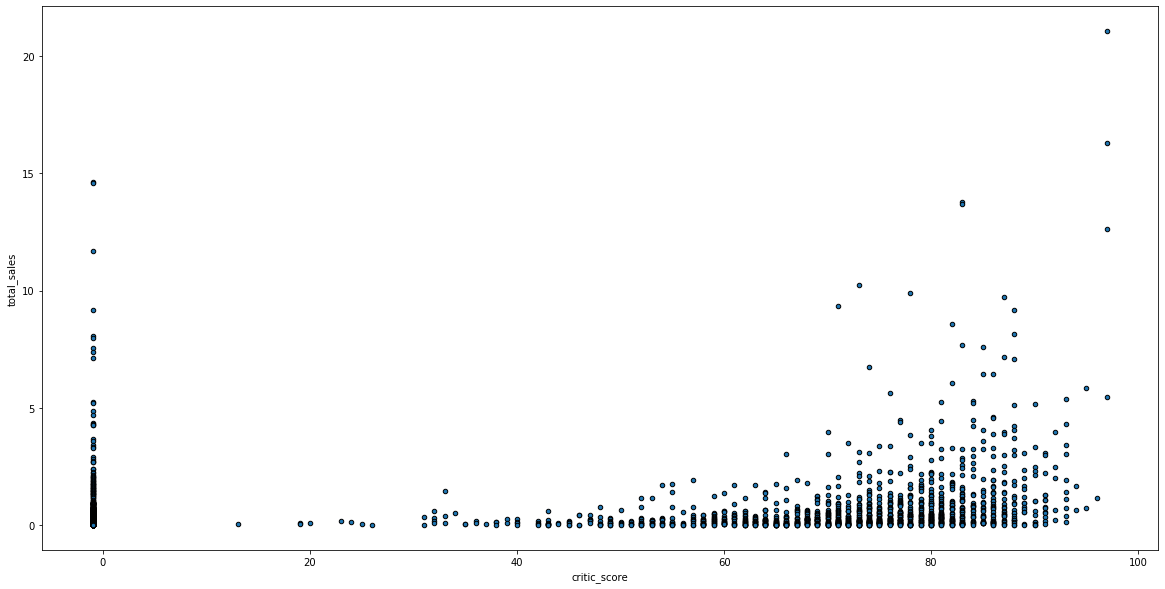

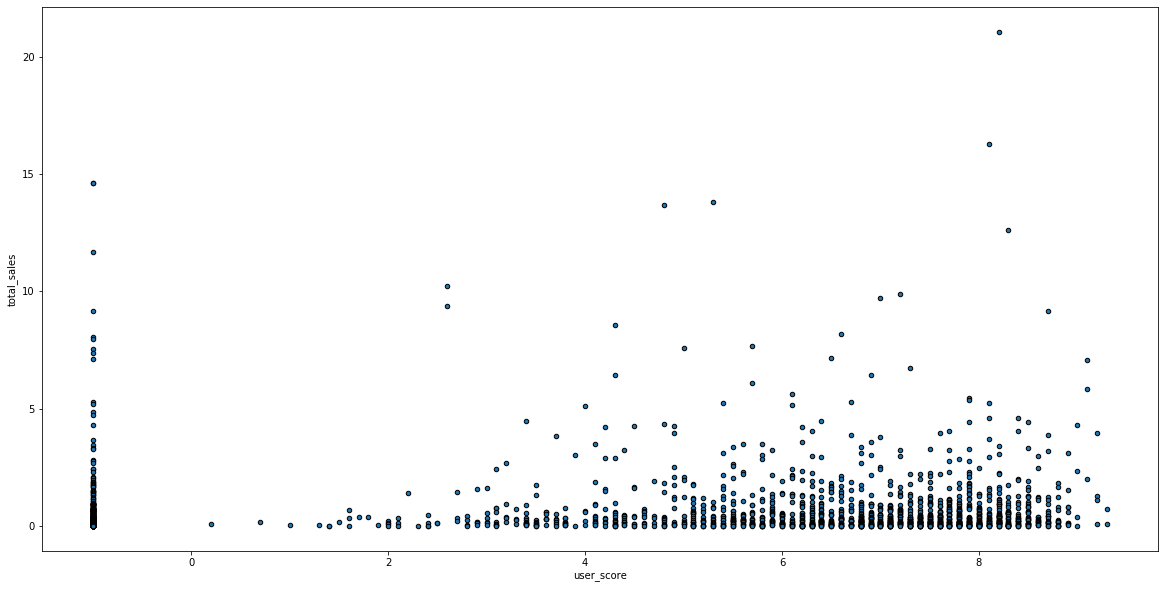

In [32]:
# Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
# Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.
# Возьмем для анализа самую популярную платформу PS3
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

ps3 = current_period[(current_period['platform'] == 'PS3') & (current_period['critic_score'] > 0)].copy()
current_period.plot(kind='scatter', x='critic_score', y='total_sales', ec='black', figsize=(20,10))
ps3 = current_period[(current_period['platform'] == 'PS3') & (current_period['user_score'] > 0)].copy()
current_period.plot(kind='scatter', x='user_score', y='total_sales', ec='black', figsize=(20,10))

X360. Проанализируем зависимость суммы продаж от оценки критиков и пользователей.

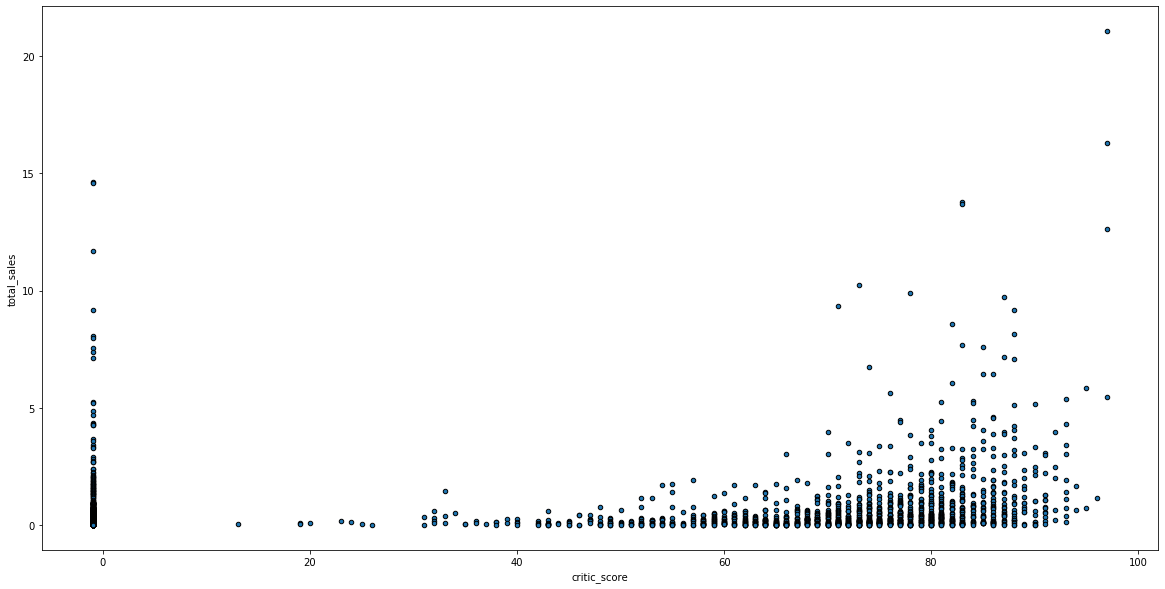

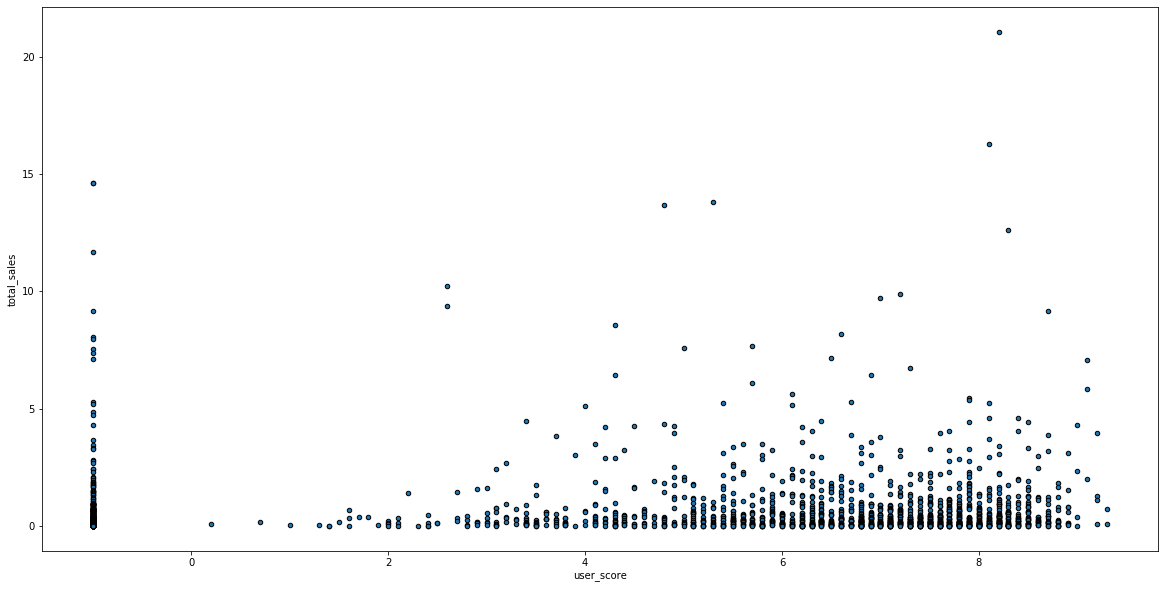

In [33]:
X360 = current_period[(current_period['platform'] == 'X360') & (current_period['critic_score'] > 0)].copy()
current_period.plot(kind='scatter', x='critic_score', y='total_sales', ec='black', figsize=(20,10))
X360 = current_period[(current_period['platform'] == 'X360') & (current_period['user_score'] > 0)].copy()
current_period.plot(kind='scatter', x='user_score', y='total_sales', ec='black', figsize=(20,10))

* Значения ниже 0 не рассматриваем, это наши индикаторные значения без рейтинга. У обоих платформ видна закономерность. Чем выше оценка пользователей и критиков, тем продажи выше.

Соотнесем выводы с продажами игр на других платформах. Для этого построим матрицу корреляции и проанализируем, как взимосвязаны оценки пользователей и критиков между собой и с общей суммой продаж.

<font color='blue'> Отфильтруем индикаторные значения "-1" </font>

In [34]:
critic_score = current_period[current_period['critic_score'] != -1]
user_score = current_period[current_period['user_score'] != -1]

Проанализируем зависимости между: 1. Оценками игроков и критиков между собой, 2. Оценками критиков и игроков от суммы продаж. Для этого построим матрицу корреляции.

In [35]:
current_period[current_period['platform'] == 'PS3'].loc[:, ['total_sales', 'critic_score','user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.298204,0.217372
critic_score,0.298204,1.000000,0.762073
user_score,0.217372,0.762073,1.000000


* Оценки критиков и пользователей имеют сильную корреляцию между собой - 0,76. Можно сделать вывод, что качество игры оценивается примерно одинаково и критиками и пользователями. А вот взаимосвязь между оценками и суммой продаж не так сильна. Значит есть еще какие-то критерии, влияющие на выручку. 

Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [36]:
top_genre = current_period.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
top_genre.head(10)


,total_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04
Platform,61.00
Racing,53.50
Fighting,44.49
Simulation,35.12


Text(0, 0.5, 'Сумма выручки')

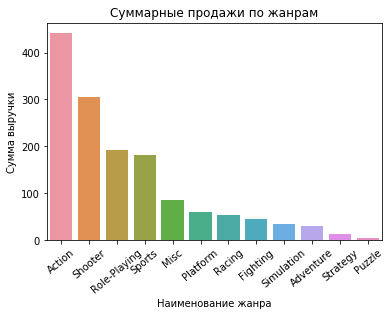

In [37]:
# посмотрим на графике
g = sns.barplot(x=top_genre.index,y=top_genre['total_sales'])
g.set_xticklabels(labels = top_genre.index, rotation=40)
plt.title("Суммарные продажи по жанрам")
plt.xlabel("Наименование жанра")
plt.ylabel("Сумма выручки")

* <font color='blue'> Давайте взглянем на данные в разрезе среднего и медианы. </font>

In [38]:
top_genre = current_period.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'mean').sort_values(by = 'total_sales', ascending = False)
top_genre.head(10)

,total_sales
genre,
Shooter,1.296723
Platform,0.717647
Sports,0.675634
Role-Playing,0.521081
Racing,0.465217
Misc,0.442917
Simulation,0.439000
Action,0.427856
Fighting,0.408165


In [39]:
top_genre = current_period.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'median').sort_values(by = 'total_sales', ascending = False)
top_genre.head(10)

,total_sales
genre,
Shooter,0.44
Sports,0.24
Platform,0.21
Role-Playing,0.14
Racing,0.14
Fighting,0.13
Action,0.12
Misc,0.12
Simulation,0.12


* <font color='blue'> Стрелялки и Спортивные игры на месте. Вместо Экшн, который улетел вниз, наверху появился жанр Платформы. За основу возьмем данные по суммарным продажам, как наиболее репрезентативные </font>

Мы видим 4 явных лидера Action, Shooter, Role-Playing, Sports. Puzzle и Strategy - жанры с самыми низкими продажами, но есть любители этих игр. В основном люди предпочитают бродилки, стрелялки, спортивные игры, однако на 3 месте ролевые. Это надо учитывать.

### Вывод. Мы провели исследовательский анализ данных и сделали следующие выводы:
* по историческим данным, платформы имеют жизненный цикл около 10 лет.
* пик популярности и максимальная выручка пришлись на период 2007-2011 год. На данный момент сектор рынка стабилизировался. Для анализа и прогнозирования продаж будем учитывать данные начиная с 2012 года. Это так называвемый период стабильности. Этот вывод подтверждается исторической статистикой на данный момент.
* на момент анализа наиболее популярные платформы: PS3 и X360. Обе приставки близки по сумме выручки и ее медианному значению.
* чем выше оценки критиков и пользователей, тем выше выручка. Ожидаемый критерий оценки качества.
* лидеры по жанрам Action, Shooter, Role-Playing, Sports. Puzzle и Strategy

## Составим портрет пользователя для каждого региона

Определим для пользователя каждого региона (NA, EU, JP): 
* Самые популярные платформы (топ-5). Опишите различия в долях продаж. 
* Самые популярные жанры (топ-5). Поясните разницу. 
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Самые популярные платформы (топ-5). Опишите различия в долях продаж.

In [40]:
# давайте создадим функцию для прорисовки графиков
def top_platforms_regions(groupby, region_sales, ax):
    pivot = current_period.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'Продажи в Северной Америке', 'eu_sales': 'Продажи в Европе', 'jp_sales': 'Продажи в Японии'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17}).set_visible(False)
    plot.set_xlabel('')
    plot.title.set_size(20)

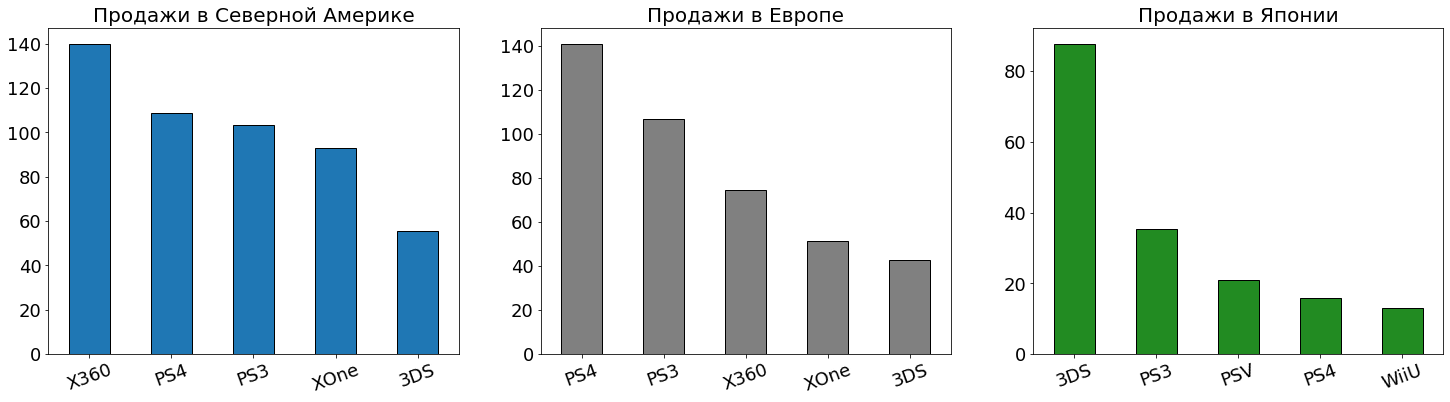

In [41]:
# поставим графики рядом для удобства анализа
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_platforms_regions('platform', 'na_sales', 0)
top_platforms_regions('platform', 'eu_sales', 1)
top_platforms_regions('platform', 'jp_sales', 2)

Посмотрев на графики можно увидеть, что ни единого лидера ни единого оутсайдера по всем регионам нет. В каждом регионе свои фавориты. Лидеры Северной Америки находятся в оутсайдерах у пользователей Японии. И наоборот, соответственно. Выбранные нами приоритетные платформы PS3 b X360 в Японии вообще не видны. Это надо учитывать при планировании 2017 года.

Самые популярные жанры (топ-5). Поясните разницу.

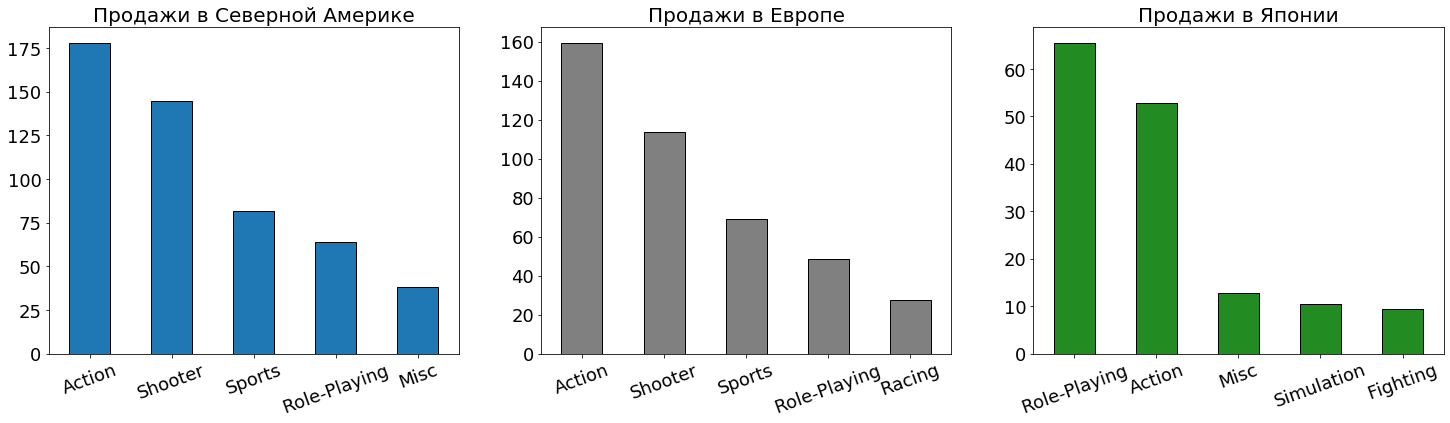

In [42]:
# посмотрим на жанры с помощью нашей функции
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_platforms_regions('genre', 'na_sales', 0)
top_platforms_regions('genre', 'eu_sales', 1)
top_platforms_regions('genre', 'jp_sales', 2)

Северная Америка и Европа имеют близкие предпрочтения по жанрам. Это Экшн, Спорт, Стрелялки, Гонки. В Японии Экшн и Спорт тоже в лидерах, но на первом месте Ролевые игры. Скорее всего это из-за особенностей местного менталитета. Любят японцы такие вещи. На графиках также хорошо видно, что рынок Северной Америки по объему сопоставим с рынками Европы и Японии вместе взятыми. Это приритетный рынок.

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

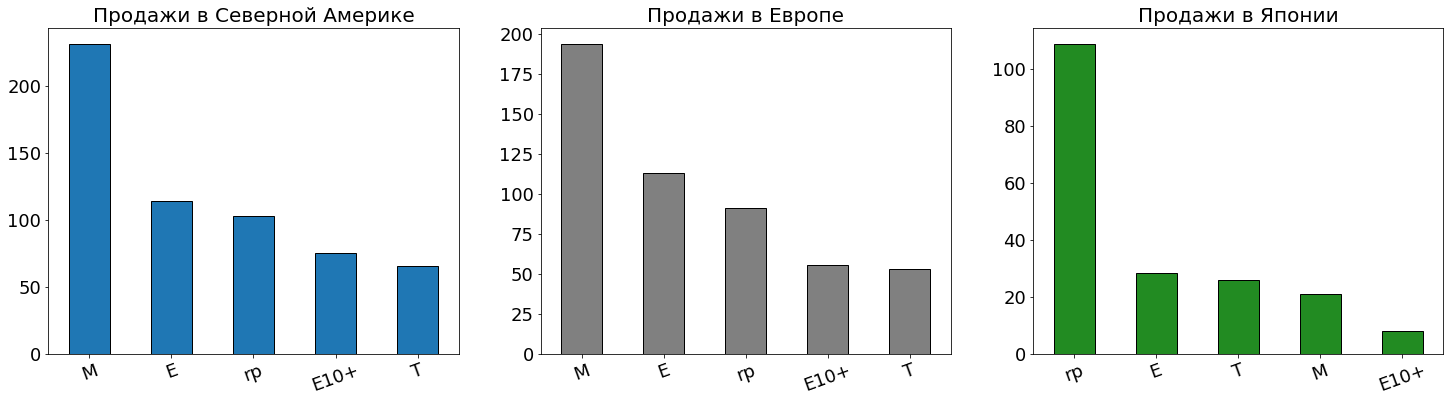

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

top_platforms_regions('rating', 'na_sales', 0)
top_platforms_regions('rating', 'eu_sales', 1)
top_platforms_regions('rating', 'jp_sales', 2)

Критерии рейтинга игр ESRB:
* «EC» («Early childhood») — «Для детей младшего возраста»: Игра подходит для детей от 3 лет и не содержит материалов, которые родители могли бы счесть неподходящими. Продукты, получившие данный рейтинг, изначально разрабатываются для детей и обычно представляют собой развивающие игры. Некоторые усложнённые развивающие игры могут иметь рейтинг «Everyone».
* «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет. Такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера. Первой игрой, которая получила данный рейтинг, стала The Simpsons Cartoon Studio, выпущенная в 1996 году. Первоначально "K-A" ("Kids to Adults")
* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать или немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены, или минимальное количество крови. Рейтинг был принят ESRB 2 марта 2005 года. Первой игрой, которая получила данный рейтинг, стала Donkey Kong: Jungle Beat.
* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.
* «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.
* «AO» («Adults Only 18+») — «Только для взрослых»: Содержание игры только для взрослых старше 18 лет. Продукты из данной категории могут содержать длительные сцены жестокого насилия и/или очень откровенное сексуальное содержимое, а также сцены с обнажением. Большинство таких игр предназначено для персональных компьютеров под управлением Microsoft Windows и Apple Macintosh. Рейтинг «Только для взрослых» является предметом многочисленных дискуссий, так как накладывает серьёзные ограничения на продажи игры.
* «RP» («Rating Pending») — «Рейтинг ожидается»: Продукт был отправлен в ESRB и ожидает присвоения рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу.

* Любимый рейтинг Северной Америки и Европы - «M» («Mature»). Люди любят жесткое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику. Печально, но надо это учитывать, если мы хотим зарабатывать на продаже игр.
* На втором месте во всех регионах «E» («Everyone») — «Для всех». Это ожидаемо.
* во всех регионах в Топ-3 попал рейтинг под названием "нет рейтинга, он ожидается". Для магазина это хорошо. Для общей нравственности плохо. Нет рейтинга, значит игра, не предназначенная для детей, может попасть им в руки. Магазину делать ничего не надо. Людям можно и нужно подумать об ужесточении контроляч за рейтингом.

### Портрет пользователя по регионам:
* Северная Америка. Пользователи отдают предпочтение продукту от Майкрософт X360. На втором месте PS. Любимые жанры Экшн, Спорт, Стрелялки. Приоритет отдают играм для взрослых.
* Европа. PS любимая платформа. Любимые жанры Экшн, Спорт, Стрелялки. Приоритет отдают играм для взрослых.
* Япония. Ожидаемо японцы любят свою Nintendo и отдают предпочтение DS. Любимый жар Ролевые игры и только потом Экшн и Спорт. Предпочтения по рейтингу - игры для всех.

## Проверим гипотезы 

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые; 
* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Зададим самостоятельно пороговое значение alpha. 
* Поясним: Как сформулировали нулевую и альтернативную гипотезы; Какой критерий применили для проверки гипотез и почему.

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* Н0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [44]:
alpha = 0.05
xbox_one_ratings = current_period[(current_period['platform'] == 'XOne') & (current_period['user_score'] > 0)]['user_score']
pc_ratings = current_period[(current_period['platform'] == 'PC') & (current_period['user_score'] > 0)]['user_score']
stat, p = ttest_ind(xbox_one_ratings, pc_ratings)

print('t = {}\np-value = {:.10e}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 0.5930304646661256
p-value = 5.5350805006e-01

Пороговое значение alpha = 0.05


Отклоняем нулевую гипотезу.
Принимаем: Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются

In [45]:
print('Среднее Xbox One: {:.2f}'.format(xbox_one_ratings.mean()))
print('Среднее PС: {:.2f}'.format(pc_ratings.mean()))

Среднее Xbox One: 6.52
Среднее PС: 6.43


Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
* Н0 (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports одинаковые.
* Н1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports отличаются.

In [46]:
alpha = 0.05
action_ratings = current_period[(current_period['genre'] == 'Action') & (current_period['user_score'] > 0)]['user_score']
sports_ratings = current_period[(current_period['genre'] == 'Sports') & (current_period['user_score'] > 0)]['user_score']
stat, p = ttest_ind(action_ratings, pc_ratings)

print('t = {}\np-value = {:.4f}'.format(stat, p))
print('\nПороговое значение alpha = 0.05')

t = 3.2960799450660034
p-value = 0.0010

Пороговое значение alpha = 0.05


Отклоняем нулевую гипотезу. Принимаем: Н1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports отличаются.

In [47]:
print('Среднее action_ratings: {:.2f}'.format(action_ratings.mean()))
print('Среднее sports_ratings: {:.2f}'.format(sports_ratings.mean()))

Среднее action_ratings: 6.83
Среднее sports_ratings: 5.46


## Общий вывод

Для формулировки общего вывода исследования давайте вернемся к постановке задачи: "Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании."
1. Самое важное на что надо обратить внимание интернет-магазину - это то, что рынок компьютерных игр не растет. Он находится в стадии стабилизации. Это значит, что пользователи уходят куда-то еще. Необходимо выяснить, а куда они ушли? Что это за новые рынки? Надо провести дополнительное исследование рынка и направить усилия и деньги в этом направлении.
2. Потенциально популярные платформы. Основные платформы на рынке - это PS, X360 и DS для Японии. Рекламный бюджет надо направить в эти направления.
3. Потенциально популярные жанры. Мы видим 4 явных лидера Action, Shooter, Role-Playing, Sports. Их и развиваем.
3. Потенциально популярные рейтинги. Основные рейтинги игр: «M» («Mature») - игры для взрослых, «E» («Everyone») — «Для всех», «T» («Teen») - «Подросткам». Сосредоточим рекламный бюджет на них.
4. Общая картина портрета пользователя близка. Есть своя специфика в Японии, надо учесть, что любимая платформа DS, а любимый жанр Role-Playing. Экш, Спорт и стрелялки любят все. В Северной Америке и Европе особенно любят игры для взрослых.

### Главная рекомендация интернет-магазину. Подключить новые рынки. Рынок мобильных игр, игр в интернете и рынок игр в соцсетях. Если этого не сделать, скоро магазин можно будет закрывать или влачить жалкое существование :)